# Advanced Protein Dimer Classification with PyTorch

This notebook demonstrates advanced neural network techniques to improve performance on the dimers_features.csv dataset, including normalization, dropout, and model size comparisons.

## Learning Objectives
- Implement advanced normalization techniques (BatchNorm, LayerNorm, GroupNorm)
- Use different dropout strategies and regularization methods
- Compare model performance based on architecture size
- Apply advanced training techniques (learning rate scheduling, early stopping)
- Analyze model complexity vs. performance trade-offs

In [53]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from torch.utils.data import Dataset, DataLoader

# Set random seed for reproducibility
SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
np.random.seed(SEED)

# Check PyTorch version and CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

def set_plot_params():
    plt.style.use("seaborn-v0_8-paper")
    plt.rcParams["font.size"] = 24
    sns.set_context("paper", font_scale=1.5)
    sns.set_style(
        "ticks",
        {
            "axes.grid": True,
            "grid.linestyle": "--",
            "grid.alpha": 0.6,
            "axes.spines.right": False,
            "axes.spines.top": False,
            "font.family": "serif",
            "axes.labelpad": 10,
        },
    )

    colors = [
        "#0173B2",
        "#DE8F05",
        "#029E73",
        "#D55E00",
        "#CC78BC",
        "#CA9161",
        "#FBAFE4",
    ]
    sns.set_palette(colors)

set_plot_params()

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB


## 1. Data Loading and Exploration

Let's start by loading the dataset and understanding its structure.

In [ ]:
!wget "https://raw.githubusercontent.com/PickyBinders/ml-ai-summer-school-vib/refs/heads/main/0_dl_pytorch_intro/data/dimers_features.csv"

In [6]:
df = pd.read_csv('dimers_features.csv')

print("=== Dataset Overview ===")
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {len(df.columns) - 1}")  # Excluding target

# Check target distribution
target_counts = df['physiological'].value_counts()
print(f"\nTarget distribution:")
print(target_counts)
print(f"Physiological ratio: {target_counts[True] / len(df):.3f}")

# Check for missing values
missing_values = df.isnull().sum()
print(f"\nMissing values:")
print(missing_values[missing_values > 0])

# Basic statistics of numerical features
print(f"\nDataset info:")
print(df.info())

=== Dataset Overview ===
Dataset shape: (1677, 69)
Number of features: 68

Target distribution:
physiological
False    841
True     836
Name: count, dtype: int64
Physiological ratio: 0.499

Missing values:
SymmetryOp1    977
SymmetryOp2    977
gene           149
superfamily    248
pfam           105
dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 69 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Unnamed: 0                                  1677 non-null   int64  
 1   pdb-id                                      1677 non-null   object 
 2   global_area                                 1677 non-null   float64
 3   global_area_per_atom                        1677 non-null   float64
 4   global_volume                               1677 non-null   float64
 5   global_volume_per_atom                      1677

## 2. Feature Selection and Data Preparation

In [7]:
categorical_cols = ['pdb-id', 'ID', 'SymmetryOp1', 'SymmetryOp2', 'gene', 'superfamily', 'pfam']
target_col = 'physiological'

# Get numerical columns
numerical_cols = [col for col in df.columns if col not in categorical_cols + [target_col]]
print(f"Number of numerical features: {len(numerical_cols)}")

# Prepare features and target
X = df[numerical_cols].values
y = df[target_col].values

print(f"Features shape: X={X.shape}, y={y.shape}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Train physiological ratio: {np.mean(y_train):.3f}")
print(f"Test physiological ratio: {np.mean(y_test):.3f}")

Number of numerical features: 61
Features shape: X=(1677, 61), y=(1677,)
Train set: (1341, 61), Test set: (336, 61)
Train physiological ratio: 0.499
Test physiological ratio: 0.497


## 3. Normalization Techniques

As we noticed, it might be important to normalize our data.

In [9]:
# Compare different normalization techniques
print("=== Normalization Techniques Comparison ===")

# Test different normalizers
normalizers = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'MinMaxScaler': MinMaxScaler()
}

normalizer_results = {}

for name, normalizer in normalizers.items():
    print(f"\nTesting {name}...")
    
    # Fit and transform
    X_train_norm = normalizer.fit_transform(X_train)
    X_test_norm = normalizer.transform(X_test)
    
    # Store results
    normalizer_results[name] = {
        'train': X_train_norm,
        'test': X_test_norm,
        'normalizer': normalizer
    }
    
    # Print statistics
    print(f"Train - Mean: {X_train_norm.mean():.3f}, Std: {X_train_norm.std():.3f}")
    print(f"Test  - Mean: {X_test_norm.mean():.3f}, Std: {X_test_norm.std():.3f}")

# Use StandardScaler for further analysis (most common choice)
best_normalizer = 'StandardScaler'
X_train_norm = normalizer_results[best_normalizer]['train']
X_test_norm = normalizer_results[best_normalizer]['test']

print(f"\nUsing {best_normalizer} for further analysis")

=== Normalization Techniques Comparison ===

Testing StandardScaler...
Train - Mean: -0.000, Std: 1.000
Test  - Mean: -0.005, Std: 0.970

Testing RobustScaler...
Train - Mean: -0.004, Std: 1.013
Test  - Mean: -0.010, Std: 0.968

Testing MinMaxScaler...
Train - Mean: 0.491, Std: 0.315
Test  - Mean: 0.490, Std: 0.314

Using StandardScaler for further analysis


## 4. Advanced Neural Network Techniques

In [10]:
# Base model class
class AdvancedDimerClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes=2, 
                 dropout_rate=0.3, normalization='batch', activation='relu'):
        super().__init__()
        
        self.normalization = normalization
        self.activation = activation
        
        layers = []
        prev_size = input_size
        
        # Build hidden layers with advanced techniques
        for i, hidden_size in enumerate(hidden_sizes):
            # Linear layer
            layers.append(nn.Linear(prev_size, hidden_size))
            
            # Normalization layer
            if normalization == 'batch':
                layers.append(nn.BatchNorm1d(hidden_size))
            elif normalization == 'layer':
                layers.append(nn.LayerNorm(hidden_size))

            
            # Activation function
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU(0.1))
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            
            if i < len(hidden_sizes) - 1:  # No dropout after last hidden layer
                if dropout_rate > 0:
                    layers.append(nn.Dropout(dropout_rate))
            
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

Create different models for our experiments

In [26]:
def create_model_architectures(input_size):
    """Create different model architectures for comparison"""
    architectures = {
        'Logistic_Regression': [1],
        'Large': [128, 64, 32, 16],
    }
    dropout_rates = [0.0, 0.25]
    normalizations = ["none", "batch"]
    activations = ["relu", "sigmoid"]
    
    models = {}
    for name, hidden_sizes in architectures.items():
        for dropout_rate in dropout_rates:
            for normalization in normalizations:
                for activation in activations:
                    model_name = f"{name}_dropout_{dropout_rate}_norm_{normalization}_act_{activation}"
                    models[model_name] = AdvancedDimerClassifier(
                        input_size=input_size,
                        hidden_sizes=hidden_sizes,
                        dropout_rate=dropout_rate,
                        normalization=normalization,
                        activation=activation
                    )
    
    return models

In [27]:
input_size = X_train_norm.shape[1]
models = create_model_architectures(input_size)

print("=== Model Architectures ===")
for name, model in models.items():
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{name} Model: {total_params:,} parameters ({trainable_params:,} trainable)")

=== Model Architectures ===
Logistic_Regression_dropout_0.0_norm_none_act_relu Model: 66 parameters (66 trainable)
Logistic_Regression_dropout_0.0_norm_none_act_sigmoid Model: 66 parameters (66 trainable)
Logistic_Regression_dropout_0.0_norm_batch_act_relu Model: 68 parameters (68 trainable)
Logistic_Regression_dropout_0.0_norm_batch_act_sigmoid Model: 68 parameters (68 trainable)
Logistic_Regression_dropout_0.25_norm_none_act_relu Model: 66 parameters (66 trainable)
Logistic_Regression_dropout_0.25_norm_none_act_sigmoid Model: 66 parameters (66 trainable)
Logistic_Regression_dropout_0.25_norm_batch_act_relu Model: 68 parameters (68 trainable)
Logistic_Regression_dropout_0.25_norm_batch_act_sigmoid Model: 68 parameters (68 trainable)
Large_dropout_0.0_norm_none_act_relu Model: 18,834 parameters (18,834 trainable)
Large_dropout_0.0_norm_none_act_sigmoid Model: 18,834 parameters (18,834 trainable)
Large_dropout_0.0_norm_batch_act_relu Model: 19,314 parameters (19,314 trainable)
Large_dro

## 5. Training Function

In [ ]:
def train_model_advanced(model, train_loader, test_loader, 
                        criterion, optimizer, scheduler, 
                        num_epochs, device, patience=15):
    """Advanced training with validation and early stopping"""
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_features, batch_labels in train_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_features, batch_labels in test_loader:
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device)
                
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()
        
        # Calculate metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        
        # Learning rate scheduling
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        else:
            scheduler.step()
        
        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), f'best_model_{model.__class__.__name__}.pth')
        else:
            patience_counter += 1
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}')
            print(f'           Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}')
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    return train_losses, val_losses, train_accuracies, val_accuracies

## 6. Data Preparation and Training Setup

In [16]:
class ProteinDimerDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


train_dataset = ProteinDimerDataset(X_train_norm, y_train)
test_dataset = ProteinDimerDataset(X_test_norm, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train loader: {len(train_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Train loader: 42 batches
Test loader: 11 batches
Using device: cuda


## 7. Model Training and Comparison

In [29]:
num_epochs = 250
learning_rate = 0.001
weight_decay = 1e-4

model_results = {}

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name} Model")
    print(f"{'='*50}")
    
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    # We didn't use AdamW in the previous notebook, but it's a good optimizer for this task
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10,
    )
    
    # Train model
    train_losses, test_losses, train_accuracies, test_accuracies = train_model_advanced(
        model, train_loader, test_loader, criterion, optimizer, scheduler, 
        num_epochs, device, patience=20
    )
    
    # Store results
    model_results[model_name] = {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }
    
    print(f"{model_name} Test Accuracy: {test_accuracies[-1]:.4f}")


Training Logistic_Regression_dropout_0.0_norm_none_act_relu Model
Epoch   0: Train Loss = 0.3924, Train Acc = 0.8389
           Val Loss = 0.4293, Val Acc = 0.8155
Epoch  10: Train Loss = 0.3818, Train Acc = 0.8419
           Val Loss = 0.4202, Val Acc = 0.8214
Epoch  20: Train Loss = 0.3590, Train Acc = 0.8546
           Val Loss = 0.3952, Val Acc = 0.8393
Epoch  30: Train Loss = 0.3410, Train Acc = 0.8635
           Val Loss = 0.3932, Val Acc = 0.8512
Epoch  40: Train Loss = 0.3314, Train Acc = 0.8673
           Val Loss = 0.4006, Val Acc = 0.8512
Early stopping at epoch 47
Logistic_Regression_dropout_0.0_norm_none_act_relu Test Accuracy: 0.8512

Training Logistic_Regression_dropout_0.0_norm_none_act_sigmoid Model
Epoch   0: Train Loss = 0.3576, Train Acc = 0.8628
           Val Loss = 0.3762, Val Acc = 0.8423
Epoch  10: Train Loss = 0.3498, Train Acc = 0.8658
           Val Loss = 0.3702, Val Acc = 0.8423
Epoch  20: Train Loss = 0.3450, Train Acc = 0.8695
           Val Loss = 0.36

# 8. Performance Analysis and Visualization

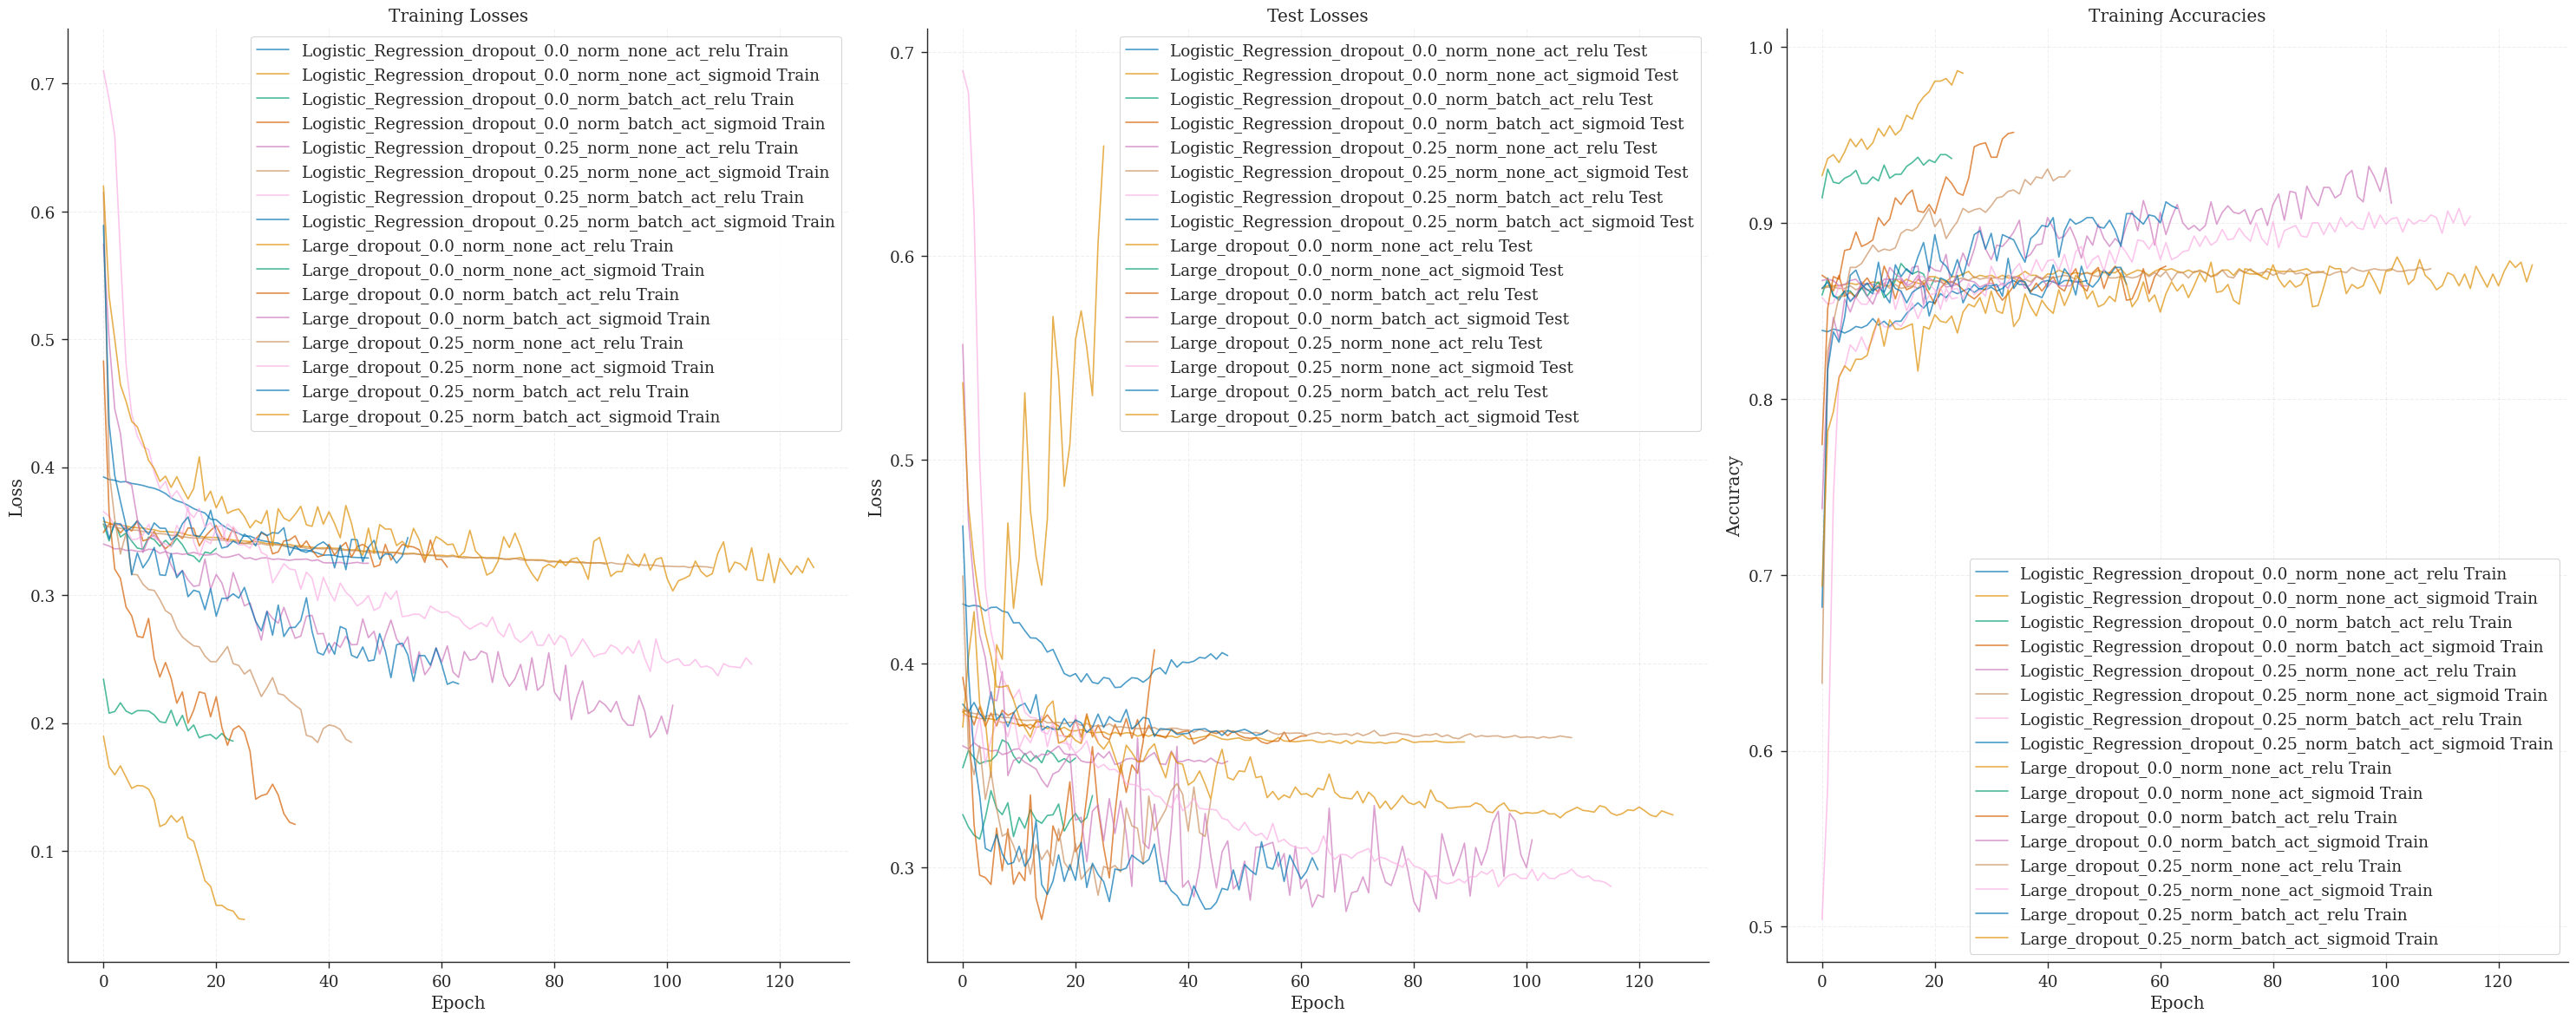

In [47]:
# Plot training progress for all models
plt.figure(figsize=(30, 12))

# Training losses
plt.subplot(1, 3, 1)
for name, results in model_results.items():
    plt.plot(results['train_losses'], label=f'{name} Train', alpha=0.7)
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation losses
plt.subplot(1, 3, 2)
for name, results in model_results.items():
    plt.plot(results['test_losses'], label=f'{name} Test', alpha=0.7)
plt.title('Test Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Training accuracies
plt.subplot(1, 3, 3)
for name, results in model_results.items():
    plt.plot(results['train_accuracies'], label=f'{name} Train', alpha=0.7)
plt.title('Training Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

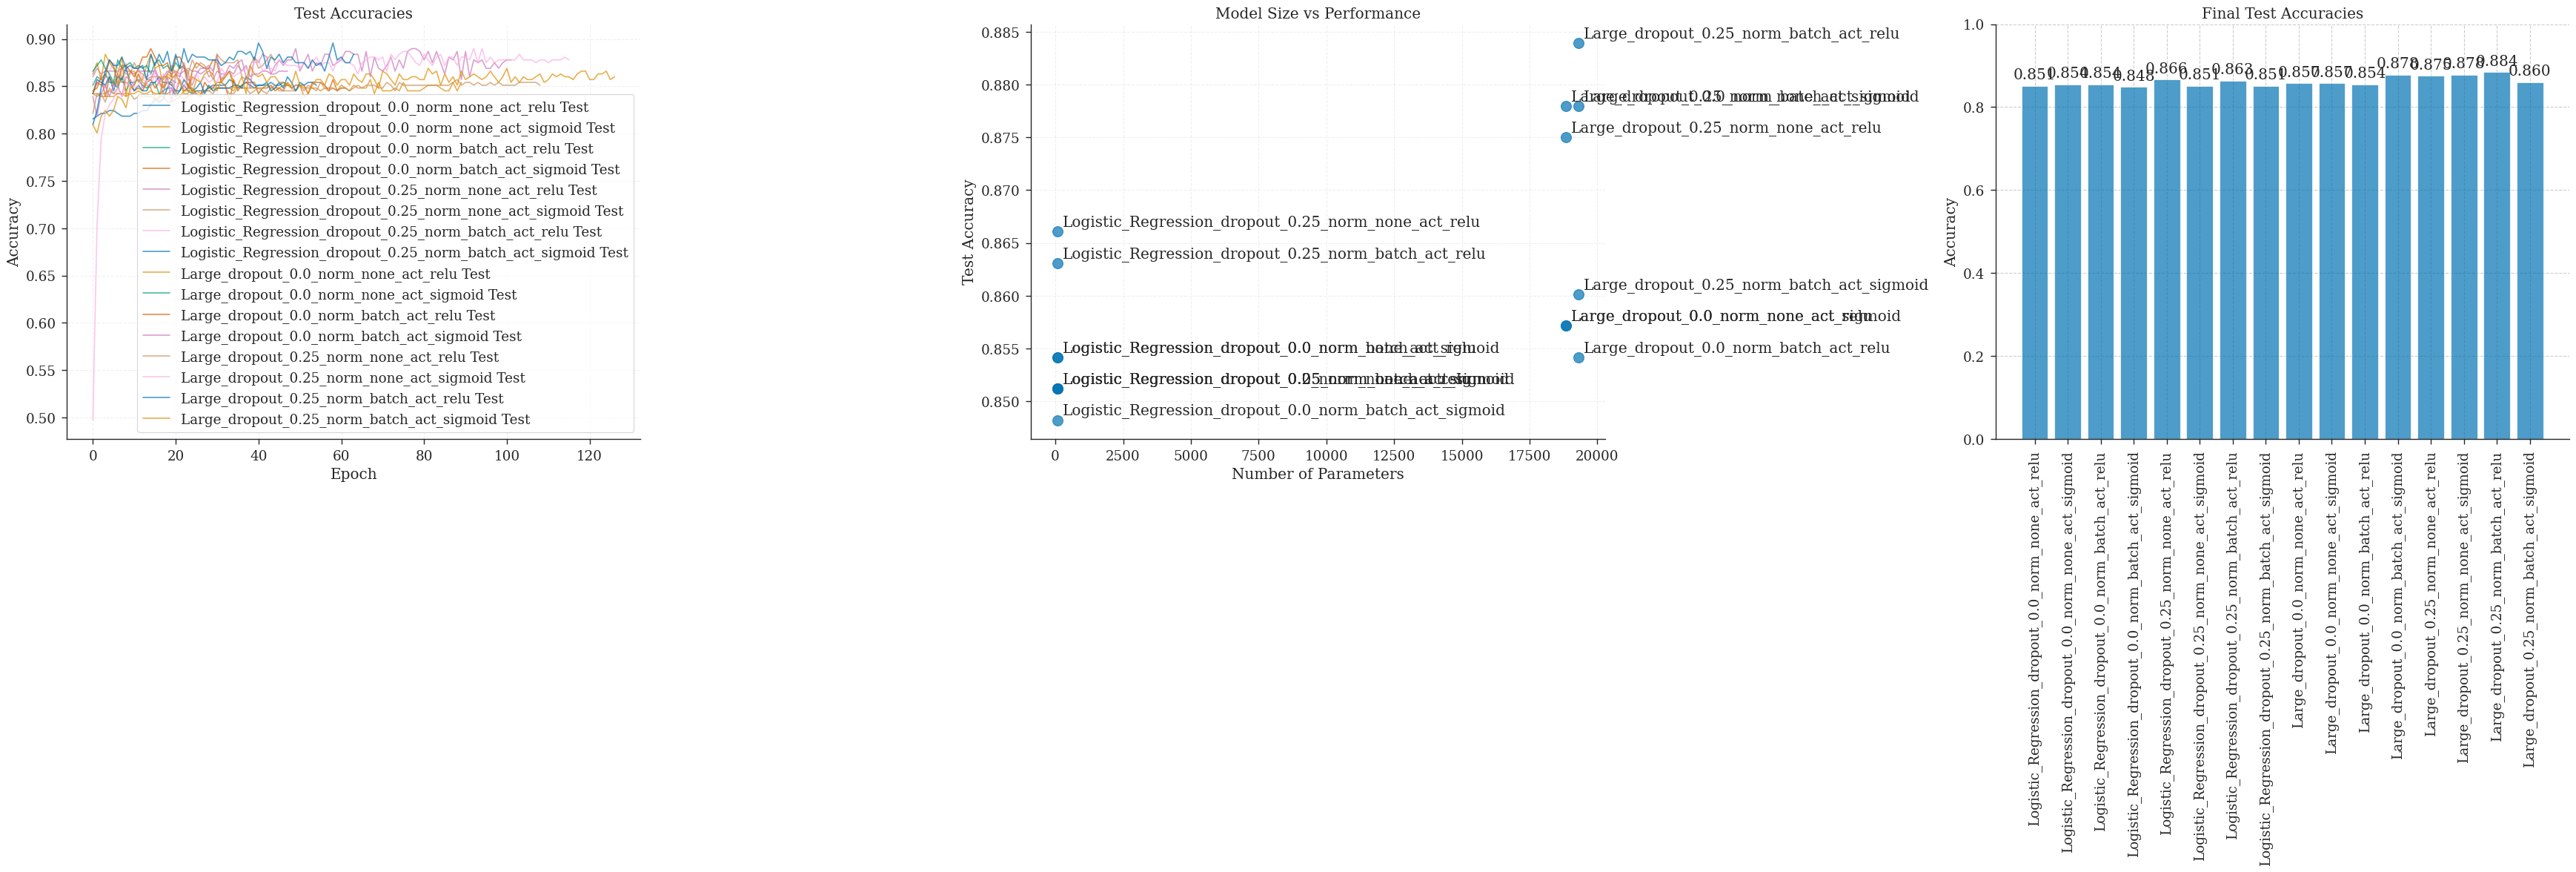

In [49]:
# Plot training progress for all models
plt.figure(figsize=(35, 12))

# Validation accuracies
plt.subplot(1, 3, 1)
for name, results in model_results.items():
    plt.plot(results['test_accuracies'], label=f'{name} Test', alpha=0.7)
plt.title('Test Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Model size vs performance
plt.subplot(1, 3, 2)
model_sizes = []
test_accuracies = []
for name, results in model_results.items():
    model = results['model']
    total_params = sum(p.numel() for p in model.parameters())
    model_sizes.append(total_params)
    test_accuracies.append(results['test_accuracies'][-1])

plt.scatter(model_sizes, test_accuracies, s=100, alpha=0.7)
for i, name in enumerate(model_results.keys()):
    plt.annotate(name, (model_sizes[i], test_accuracies[i]), 
                xytext=(5, 5), textcoords='offset points')
plt.xlabel('Number of Parameters')
plt.ylabel('Test Accuracy')
plt.title('Model Size vs Performance')
plt.grid(True, alpha=0.3)

# Final test accuracies comparison
plt.subplot(1, 3, 3)
names = list(model_results.keys())
accuracies = [model_results[name]['test_accuracies'][-1] for name in names]
bars = plt.bar(names, accuracies, alpha=0.7)
plt.title('Final Test Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## 9. Best Model Analysis

Here we will try to better analyze performance of the best model, covering different classification metrics.

In [55]:
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['test_accuracies'][-1])
best_model = model_results[best_model_name]['model']


best_model.eval()
test_probs = []
test_labels = []
test_preds = []

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        outputs = best_model(batch_features)
        probs = F.softmax(outputs, dim=1)
        test_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
        test_labels.extend(batch_labels.numpy())
        test_preds.extend(outputs.argmax(dim=1).cpu().numpy())

results_df = pd.DataFrame({
    'Physiological_Probability': test_probs,
    'Predicted_Class': test_preds,
    'True_Class': test_labels,
})

print("Prediction Analysis:")
print(f"Total predictions: {len(results_df)}")

Prediction Analysis:
Total predictions: 336


In [57]:
results_df.head()

,Physiological_Probability,Predicted_Class,True_Class
0,0.047105,0,0
1,0.835896,1,0
2,0.943020,1,1
3,0.057743,0,0
4,0.961235,1,1


### Basic metrics that require hard labels as predictions

In [62]:
print(f"Evaluating {best_model_name} model...")

# Calculate basic metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)

print(f"\nBasic Classification Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Evaluating Large_dropout_0.25_norm_batch_act_relu model...

Basic Classification Metrics:
Accuracy:  0.8839
Precision: 0.8636
Recall:    0.9102
F1-Score:  0.8863


In [63]:
print(f"\n=== Metric Interpretations ===")
print(f"Accuracy:  Out of all predictions, what fraction were correct?")
print(f"          {accuracy:.1%} of all predictions were correct")
print(f"Precision: Out of all predicted positive cases, what fraction were actually positive?")
print(f"          {precision:.1%} of predicted physiological dimers were actually physiological")
print(f"Recall:    Out of all actual positive cases, what fraction did we catch?")
print(f"          {recall:.1%} of actual physiological dimers were correctly identified")
print(f"F1-Score:  Harmonic mean of precision and recall (balanced measure)")
print(f"          {f1:.1%} - balanced performance between precision and recall")


=== Metric Interpretations ===
Accuracy:  Out of all predictions, what fraction were correct?
          88.4% of all predictions were correct
Precision: Out of all predicted positive cases, what fraction were actually positive?
          86.4% of predicted physiological dimers were actually physiological
Recall:    Out of all actual positive cases, what fraction did we catch?
          91.0% of actual physiological dimers were correctly identified
F1-Score:  Harmonic mean of precision and recall (balanced measure)
          88.6% - balanced performance between precision and recall


### Confusion Matrix

Text(0.5, 16.999999999999986, 'Predicted Label')

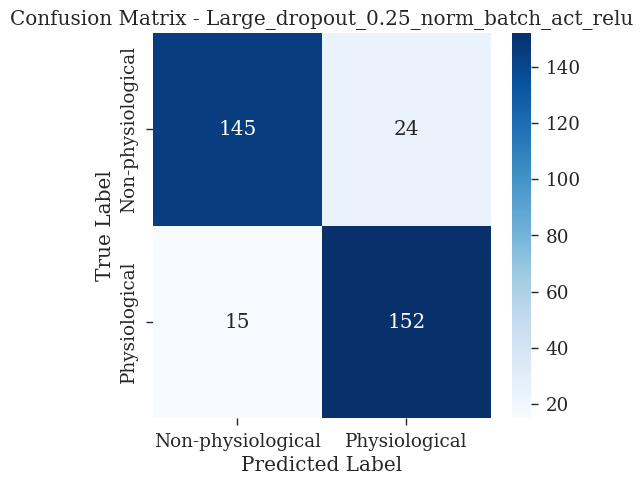

In [64]:
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(12, 5))

# Plot 1: Basic confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-physiological', 'Physiological'],
            yticklabels=['Non-physiological', 'Physiological'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label');

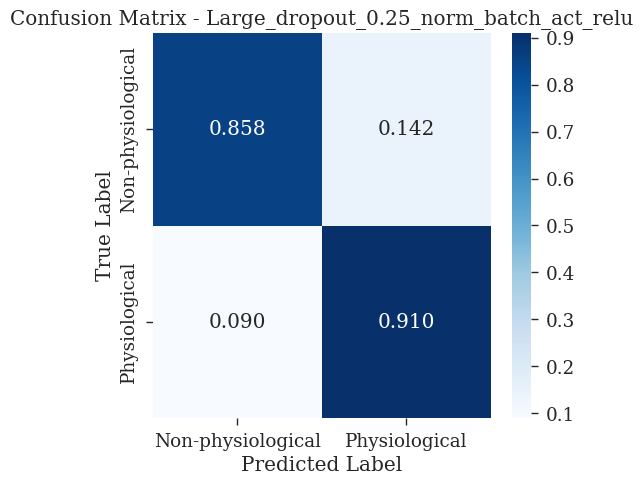

In [69]:
cm_normalized = confusion_matrix(test_labels, test_preds, normalize='true')

plt.figure(figsize=(12, 5))

# Plot 1: Basic confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=['Non-physiological', 'Physiological'],
            yticklabels=['Non-physiological', 'Physiological'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label');

### Distribution of predicted probabilities

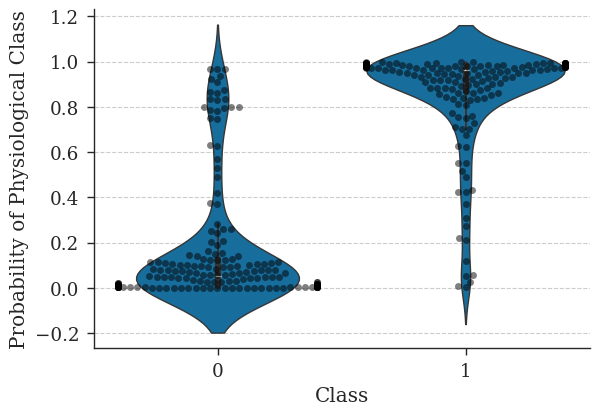

In [72]:
sns.violinplot(x=test_labels, y=test_probs)
sns.swarmplot(x=test_labels, y=test_probs, color='black', alpha=0.5)
plt.xlabel("Class")
plt.ylabel("Probability of Physiological Class");

### ROC curve


=== ROC Curve Explanation ===
ROC (Receiver Operating Characteristic) Curve:
- X-axis: False Positive Rate (FPR) = FP/(FP+TN)
- Y-axis: True Positive Rate (TPR) = TP/(TP+FN) = Recall
- AUC (Area Under Curve) = 0.949
- Perfect classifier: AUC = 1.0
- Random classifier: AUC = 0.5
- Our model: AUC = 0.949 (Good performance)


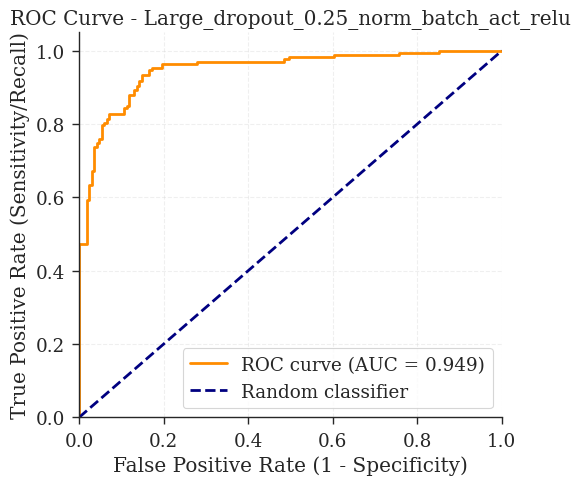

In [60]:
# Calculate ROC curve and AUC
fpr, tpr, roc_thresholds = roc_curve(test_labels, test_probs)
roc_auc = roc_auc_score(test_labels, test_probs)

# Plot ROC curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Explain ROC curve
print(f"\n=== ROC Curve Explanation ===")
print(f"ROC (Receiver Operating Characteristic) Curve:")
print(f"- X-axis: False Positive Rate (FPR) = FP/(FP+TN)")
print(f"- Y-axis: True Positive Rate (TPR) = TP/(TP+FN) = Recall")
print(f"- AUC (Area Under Curve) = {roc_auc:.3f}")
print(f"- Perfect classifier: AUC = 1.0")
print(f"- Random classifier: AUC = 0.5")
print(f"- Our model: AUC = {roc_auc:.3f} ({'Good' if roc_auc > 0.8 else 'Fair' if roc_auc > 0.7 else 'Poor'} performance)")

In [ ]:
# Show different threshold points
threshold_points = [0.2, 0.5, 0.8]
print(f"\nThreshold Analysis:")
for threshold in threshold_points:
    idx = np.argmin(np.abs(roc_thresholds - threshold))
    fpr_val = fpr[idx]
    tpr_val = tpr[idx]
    print(f"Threshold {threshold:.1f}: FPR={fpr_val:.3f}, TPR={tpr_val:.3f}")


Threshold Analysis:
Threshold 0.2: FPR=0.195, TPR=0.964
Threshold 0.5: FPR=0.142, TPR=0.916
Threshold 0.8: FPR=0.071, TPR=0.826


### PR curve

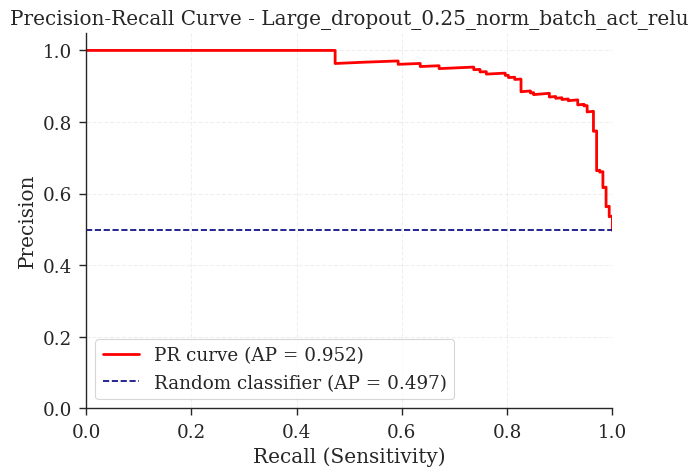


=== Precision-Recall Curve Explanation ===
Precision-Recall Curve:
- X-axis: Recall (Sensitivity) = TP/(TP+FN)
- Y-axis: Precision = TP/(TP+FP)
- AP (Average Precision) = 0.952
- Perfect classifier: AP = 1.0
- Random classifier: AP = proportion of positive class = 0.497
- Our model: AP = 0.952


In [74]:
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(test_labels, test_probs)
pr_auc = average_precision_score(test_labels, test_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall_curve, precision_curve, color='red', lw=2, label=f'PR curve (AP = {pr_auc:.3f})')
plt.axhline(y=np.mean(test_labels), color='navy', linestyle='--', 
            label=f'Random classifier (AP = {np.mean(test_labels):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model_name}')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Explain Precision-Recall curve
print(f"\n=== Precision-Recall Curve Explanation ===")
print(f"Precision-Recall Curve:")
print(f"- X-axis: Recall (Sensitivity) = TP/(TP+FN)")
print(f"- Y-axis: Precision = TP/(TP+FP)")
print(f"- AP (Average Precision) = {pr_auc:.3f}")
print(f"- Perfect classifier: AP = 1.0")
print(f"- Random classifier: AP = proportion of positive class = {np.mean(test_labels):.3f}")
print(f"- Our model: AP = {pr_auc:.3f}")

In [75]:
print(f"\nWhy PR Curve Matters for Imbalanced Data:")
print(f"- Our dataset has {np.mean(test_labels):.1%} positive cases")
print(f"- ROC curve can be misleading for imbalanced data")
print(f"- PR curve focuses on the positive class performance")
print(f"- Better metric for imbalanced classification problems")


Why PR Curve Matters for Imbalanced Data:
- Our dataset has 49.7% positive cases
- ROC curve can be misleading for imbalanced data
- PR curve focuses on the positive class performance
- Better metric for imbalanced classification problems


## 10. Threshold Analysis

In [76]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
threshold_metrics = []

print(f"\n=== Threshold Analysis ===")
print(f"Analyzing how different probability thresholds affect metrics:")

for threshold in thresholds:
    # Apply threshold
    predictions_threshold = (np.array(test_probs) >= threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(test_labels, predictions_threshold)
    prec = precision_score(test_labels, predictions_threshold)
    rec = recall_score(test_labels, predictions_threshold)
    f1 = f1_score(test_labels, predictions_threshold)
    
    threshold_metrics.append({
        'threshold': threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })
    
    print(f"Threshold {threshold:.1f}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}")


=== Threshold Analysis ===
Analyzing how different probability thresholds affect metrics:
Threshold 0.1: Acc=0.815, Prec=0.740, Rec=0.970, F1=0.839
Threshold 0.2: Acc=0.878, Prec=0.821, Rec=0.964, F1=0.887
Threshold 0.3: Acc=0.890, Prec=0.849, Rec=0.946, F1=0.895
Threshold 0.4: Acc=0.890, Prec=0.857, Rec=0.934, F1=0.894
Threshold 0.5: Acc=0.884, Prec=0.864, Rec=0.910, F1=0.886
Threshold 0.6: Acc=0.881, Prec=0.871, Rec=0.892, F1=0.882
Threshold 0.7: Acc=0.878, Prec=0.880, Rec=0.874, F1=0.877
Threshold 0.8: Acc=0.875, Prec=0.914, Rec=0.826, F1=0.868
Threshold 0.9: Acc=0.827, Prec=0.950, Rec=0.689, F1=0.799


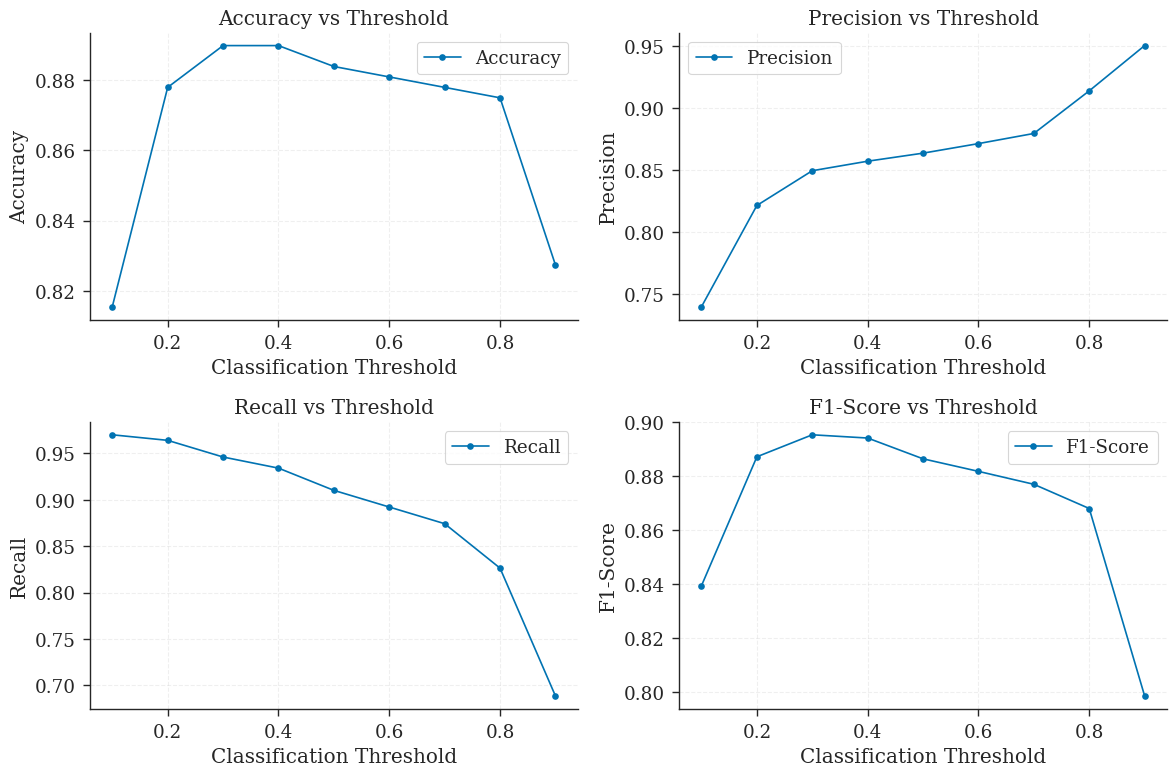

In [77]:
threshold_df = pd.DataFrame(threshold_metrics)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(threshold_df['threshold'], threshold_df['accuracy'], 'o-', label='Accuracy')
plt.xlabel('Classification Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(threshold_df['threshold'], threshold_df['precision'], 'o-', label='Precision')
plt.xlabel('Classification Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Threshold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(threshold_df['threshold'], threshold_df['recall'], 'o-', label='Recall')
plt.xlabel('Classification Threshold')
plt.ylabel('Recall')
plt.xlabel('Classification Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Threshold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(threshold_df['threshold'], threshold_df['f1'], 'o-', label='F1-Score')
plt.xlabel('Classification Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [78]:
optimal_idx = np.argmax(threshold_df['f1'])
optimal_threshold = threshold_df.iloc[optimal_idx]['threshold']
optimal_f1 = threshold_df.iloc[optimal_idx]['f1']

print(f"\nOptimal Threshold Analysis:")
print(f"Best F1-Score: {optimal_f1:.3f} at threshold {optimal_threshold:.1f}")
print(f"This threshold balances precision and recall optimally")


Optimal Threshold Analysis:
Best F1-Score: 0.895 at threshold 0.3
This threshold balances precision and recall optimally


## What are the most problematic observations?

We have a column **difficult**, which indicates dimers that are harder to classify, we want to check how our model works for them:

- Make another train/test split but where **difficult** observations are only in test set (the same 0.2 ratio).
- Train the best model.
- Test it and check how the model performed to **difficult** targets.

In [ ]:
df[["physiological", "difficult"]].value_counts()

physiological  difficult
False          False        829
True           False        825
False          True          12
True           True          11
Name: count, dtype: int64